The connectome of the organoid is a weighted (scaled via pass-to-ranks), directed, hollow graph. Consider an ordered list of time stamps, $t=[1,2, \cdots, m]$, where $m = 39$. Let $A_i$ be the adjacency matrix for the connectome at time $i \in t$, with each graph having a known 1-1 vertex correspondance, i.e. there is a single vertex set, of size $n$, for all $m$, though some vertices in some graphs may have $degree=0$. 

Let $f(P) = trace (A P B^T P^T)$, (such that P be some $n x n$ permutation matrix, and $A, B$ be two $n x n$ real adjacency matrices) be the objective function for the Graphing Matching Problem, where $GM(A, B)$ returns an approximation of $P$ that maximizes $f(P)$, evaluated via the Fast Approximate Quadratic assignment algorithm (FAQ), initialized at the barycenter. We conduct the following experiment to evaluate how much GM may improve the objective function value over time, as compared to the known 1-1 correspondance of the vertices.

For all $i \in [1,2, \cdots, m-1]$, sample $A_i$ and $A_{i+1}$, where $A_i$ and $A_{i+1}$ are aligned based on the known 1-1 vertex correspondance. Evaluate $P_i = GM(A_i, A_{i+1})$, and compare the values $f(I) = trace(A_i I A_{i+1}^T I^T) = trace (A_i, A_{i+1})$, where $I$ is the $nxn$ identity matrix, representing the objective function value at the 1-1 correspondance, and $f(P_i)$, the objective function evaluated via GM. Fig 1 demonstrates the objective function values over time, and we though we observe that the two classes result in similar trends, the objective functions values via GM are \textit{always} greater than those of the 1-1 correspondance (Fig 2).

From these results, we wish to know whether the 1-1 correspondance is close to good. To evaluate this, we will consider the ajacency matrices $A_{26}$ and $A_{27}$. On a histogram of $f(P_r) = trace (A_{26} P_r A_{27}^T P_r^T)$, where $P_r \in$ the set of 100 random $nxn$ permutation matrices, we indicate $f(I)$ and $f(P_{26})$. Additionally, we take advantage of FAQ's ability to initialize at any doubly-stochastic matrix, and indicate on the histogram $f(GM_I)$ and $f(GM_{P_r})$, where $GM_I$ and $GM_{P_r}$ are the permutation matrices returned by FAQ initiliazed at the identity matrix and random permutation matrix, respectively (Fig 3)(For the random permutation matrices, we display the average of these values). As we see, all values indicated actually perform relatively well compared to the PDF of possible objective function values.

The performance of FAQ can also be defined through it matching accuracy, as the fraction of vertices correctly labelled. Table 1 shows the matching accuracies for FAQ initialized at the barycenter, $I$, and $P_r$. FAQ initialized at $I$ results in a noticeably higher matching accuracy. Additionally, the weighted in and out degree for nodes that were correctly matched are notably higher than those which were incorrectly matched (Fig 4). 

In [2]:
# collapse
import sys
sys.path
sys.path.insert(0, '/Users/asaadeldin/Downloads/GitHub/scipy')
from scipy.optimize import quadratic_assignment

In [3]:
# collapse
%pylab inline
import pandas as pd
from graspy.utils import pass_to_ranks
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [4]:
# collapse
def load_adj(file):
    df = pd.read_csv(f'org_sig1_max/{file}.csv', names = ['from', 'to', 'weight'])
    return df
def match_ratio(inds, n):
        return np.count_nonzero(inds == np.arange(n)) / n

In [5]:
# collapse
times = [1,4,11,17,25,34,45,48,52,55,63,69,70,76,80,83,90,97,103,111,117,129,130,132,139,140,146,153,160,167,
         174,181,188,192,195,202,209,216,223,229]

In [360]:
# collapse
from scipy.stats import sem
t = 1
ofvs = np.zeros((len(times)-1,2)) # [opt_ofv, gm_ofv]
for i in range(len(times)-1):
    # constructing the adjacency matrices
    Ael = load_adj(times[i])
    Bel = load_adj(times[i+1])
    nodes = np.concatenate((Ael['from'],Ael['to'],Bel['from'],Bel['to']), axis=0)
    nodes = list(set(nodes))
    n = len(nodes)
    A = np.zeros((n,n))
    B = np.zeros((n,n))
    row_list_A = [nodes.index(x) for x in Ael['from']]
    col_list_A = [nodes.index(x) for x in Ael['to']]
    A[row_list_A, col_list_A] = Ael['weight']
    row_list_B = [nodes.index(x) for x in Bel['from']]
    col_list_B = [nodes.index(x) for x in Bel['to']]
    B[row_list_B, col_list_B] = Bel['weight']
    A = pass_to_ranks(A)
    B = pass_to_ranks(B)
    Atil, Btil = adopted_pad(A,B)
    A, B = naive_pad(A,B)
#     gm_ofvs = np.zeros(t)
#     for j in range(t):
    gmp = {'maximize':True, 'shuffle_input': True}
    res = quadratic_assignment(Atil,Btil, options=gmp)
    #gm_ofvs[j] = res.fun
    gm_ofv_ns = calc_score(A, B, res.col_ind)
    opt_ofv = (A*B).sum()
    ofvs[i,:] = [opt_ofv, gm_ofv_ns]

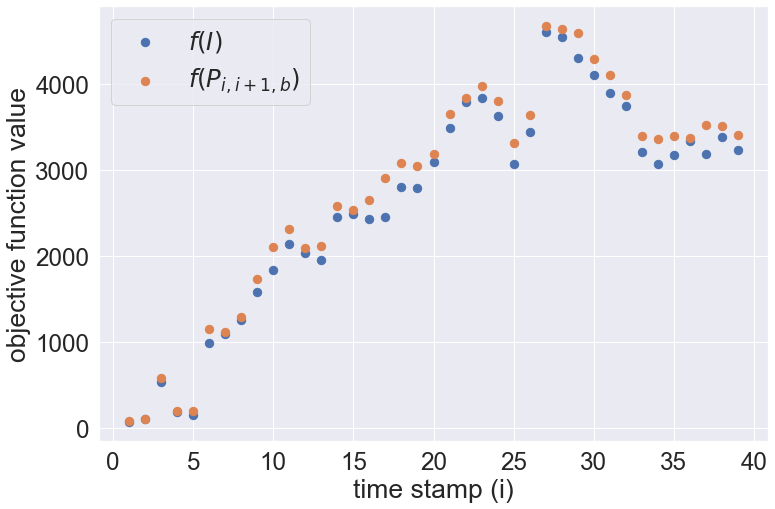

In [361]:
# collapse
#sns.set_context('talk')
sns.set(font_scale = 2.2)
#sns.set(rc={'figure.figsize':(12,8)})
plt.scatter(np.arange(1, len(times)), ofvs[:,0], label = r'$f (I)$', s=70)
plt.scatter(np.arange(1, len(times)), ofvs[:,1], label = r'$f (P_{i, i+1, b})$', s=70)
#plt.errorbar(np.arange(len(times)-1),ofvs[:,1], ofvs[:,2],label = 'average gm ofv +/- 2 s.e.',marker='o', fmt = ' ' ,capsize=3, elinewidth=1, markeredgewidth=1,color='orange')
plt.legend()
#plt.title('Figure 1')
plt.ylabel('objective function value')
plt.xlabel('time stamp (i)')
plt.savefig('Figure2.png')


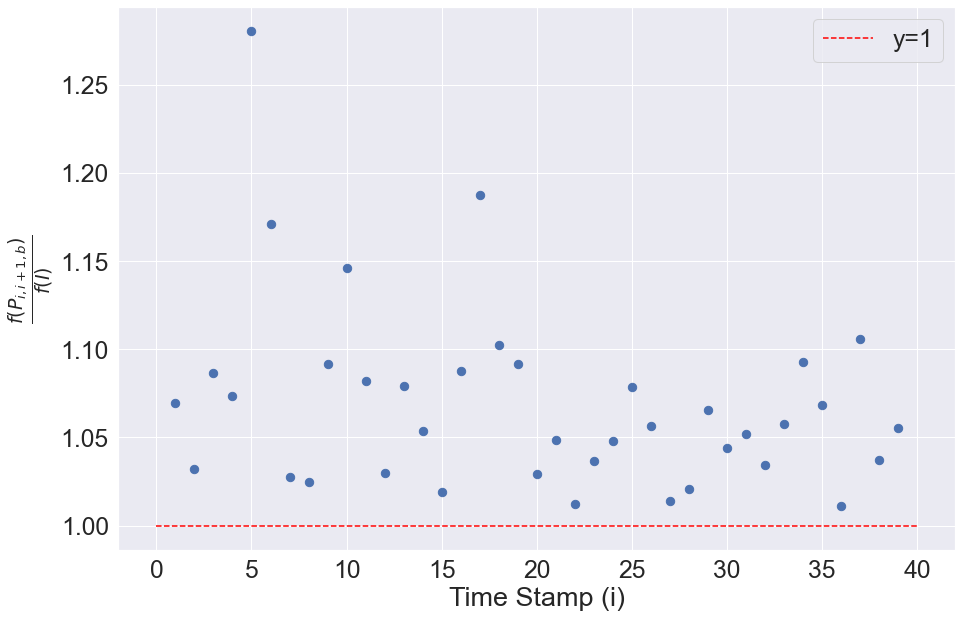

In [283]:
# collapse
# sns.set_context('talk')
sns.set(font_scale = 2.25)
plt.scatter(np.arange(1, len(times)), ofvs[:,1]/ofvs[:,0], s=70)
plt.hlines(1,0,40,linestyles='dashed', color = 'red', label='y=1')
#plt.title('Figure 2')
plt.legend()
plt.xlabel('Time Stamp (i)')
plt.ylabel(r'$\frac{f (P_{i, i+1, b})}{f (I)}$')
plt.savefig('Figure3.png')

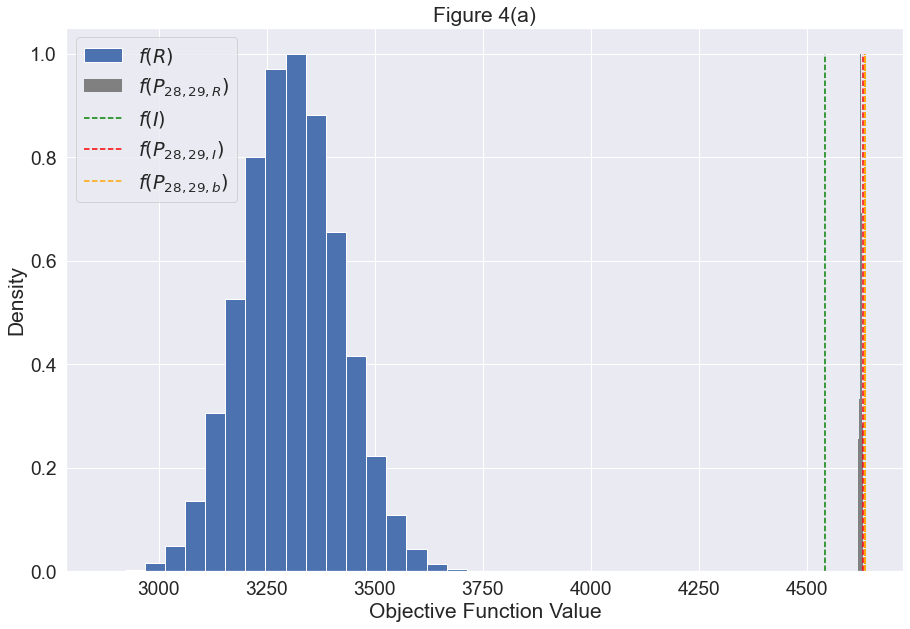

In [259]:
import seaborn as sns
sns.set(font_scale = 1.75)
#sns.set(rc={'figure.figsize':(15,10)})
counts, bins = np.histogram(rands, bins = 20)
plt.hist(bins[:-1], bins, weights = counts/(max(counts)), label = r'$f(R)$')
counts, bins = np.histogram(fgmrp, bins=5)
plt.hist(bins[:-1], bins, weights = counts/(max(counts)), label = r'$f(P_{28,29, R})$', color = 'grey', lw=0)
#plt.hist(rands, bins=20, density=True, label = 'f(randomP)')
# plt.hist(fgmrp, bins = 10, label = 'f(GM(P_r))')
plt.vlines(fp,0,1,linestyles='dashed', color = 'green', label=r'$f(I)$')
plt.vlines(fgmp,0,1,linestyles='dashed', color = 'red', label=r'$f(P_{28,29, I})$')
plt.vlines(fgmb,0,1,linestyles='dashed', color = 'orange', label=r'$f(P_{28,29, b})$')
#plt.vlines(fgmrp,0,15000,linestyles='dashed', color = 'blue', label='f(GM(P_r))')

plt.legend()
plt.title('Figure 4(a)')
plt.xlabel('Objective Function Value')
plt.ylabel('Density')
#plt.title('Figure 3')
plt.savefig('Figure4a.png')

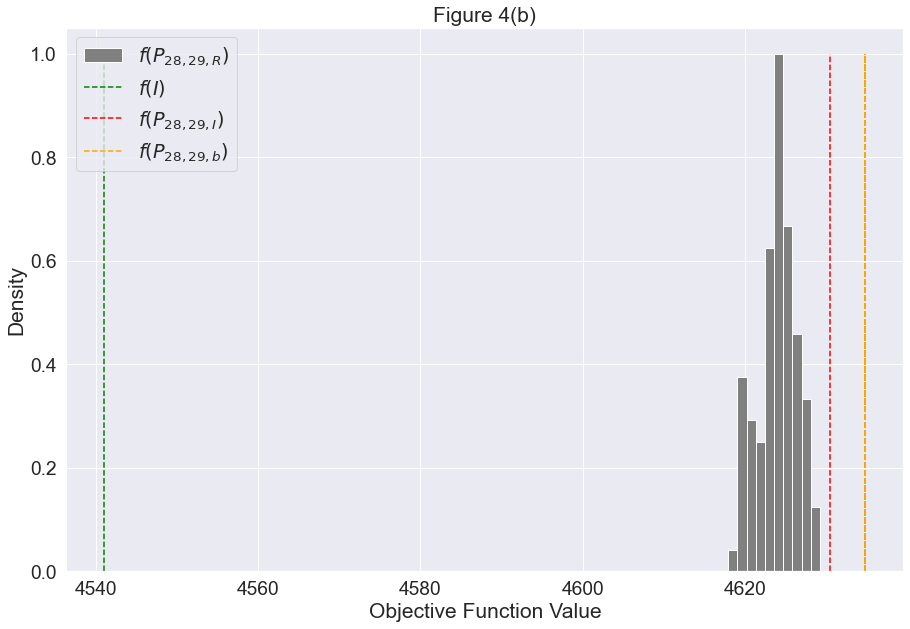

In [258]:
import seaborn as sns
sns.set(font_scale = 1.75)
#sns.set(rc={'figure.figsize':(15,10)})
counts, bins = np.histogram(fgmrp, bins=10)
plt.hist(bins[:-1], bins, weights = counts/(max(counts)), label = r'$f(P_{28,29, R})$', color = 'grey')
#plt.hist(rands, bins=20, density=True, label = 'f(randomP)')
# plt.hist(fgmrp, bins = 10, label = 'f(GM(P_r))')
plt.vlines(fp,0,1,linestyles='dashed', color = 'green', label=r'$f(I)$')
plt.vlines(fgmp,0,1,linestyles='dashed', color = 'red', label=r'$f(P_{28,29, I})$')
plt.vlines(fgmb,0,1,linestyles='dashed', color = 'orange', label=r'$f(P_{28,29, b})$')
#plt.vlines(fgmrp,0,15000,linestyles='dashed', color = 'blue', label='f(GM(P_r))')

plt.legend()
plt.title('Figure 4(b)')
plt.xlabel('Objective Function Value')
plt.ylabel('Density')
#plt.title('Figure 3')
plt.savefig('Figure4b.png')

In [16]:
# plt.vlines(mrgmp,0,1500,linestyles='dashed', color = 'red', label='f(gm(P*))')
# plt.vlines(mrgmb,0,1500,linestyles='dashed', color = 'yellow', label='f(gm(barycenter))')
# plt.vlines(mrgmrp,0,1500,linestyles='dashed', color = 'blue', label='f(gm(randomP))')
mat = np.asarray([['I', 'Barycenter', 'P_r'],[mrgmp, mrgmb, mrgmrp]])
df = pd.DataFrame(mat.T,columns=['Initialization','Matching accuracy'])
print('Table 1')
print(df)

Table 1
  Initialization    Matching accuracy
0              I   0.6557377049180327
1     Barycenter  0.16393442622950818
2            P_r  0.16393442622950818


In [17]:
plt.errorbar(['in degree']+['out degree'], [np.mean(in_matched), np.mean(out_matched)], [2* sem(in_matched), 2*sem(out_matched)],marker='o', fmt = ' ' ,capsize=3, elinewidth=1, markeredgewidth=1,color='red', label = 'Correctly Matched')
plt.errorbar(['in degree']+['out degree'], [np.mean(in_unmatched), np.mean(out_unmatched)], [2* sem(in_unmatched), 2*sem(out_unmatched)],marker='o', fmt = ' ' ,capsize=3, elinewidth=1, markeredgewidth=1,color='blue', label = 'Not Correctly Matched')
plt.title('Figure 4') 
plt.legend()
plt.ylabel('Average Degree +/- 2 s.e.')
             
             
             

NameError: name 'in_matched' is not defined

In [49]:
# collapse
from scipy.stats import sem
t = 1
ofvs = np.zeros((len(times)-1,2)) # [opt_ofv, gm_ofv]
for i in range(len(times)-1):
    # constructing the adjacency matrices
    Ael = load_adj(times[i])
    Bel = load_adj(times[i+1])
    nodes = np.concatenate((Ael['from'],Ael['to'],Bel['from'],Bel['to']), axis=0)
    nodes = list(set(nodes))
    n = len(nodes)
    A = np.zeros((n,n))
    B = np.zeros((n,n))
    row_list_A = [nodes.index(x) for x in Ael['from']]
    col_list_A = [nodes.index(x) for x in Ael['to']]
    A[row_list_A, col_list_A] = Ael['weight']
    row_list_B = [nodes.index(x) for x in Bel['from']]
    col_list_B = [nodes.index(x) for x in Bel['to']]
    B[row_list_B, col_list_B] = Bel['weight']
    A = pass_to_ranks(A)
    B = pass_to_ranks(B)
#     gm_ofvs = np.zeros(t)
#     for j in range(t):
    gmp = {'maximize':True, 'shuffle_input': False, 'init_J': np.identity(n)}
    res = quadratic_assignment(A,B, options=gmp)
    #gm_ofvs[j] = res.fun
    gm_ofv_ns = res.fun
    opt_ofv = (A*B).sum()
    ofvs[i,:] = [opt_ofv, gm_ofv_ns]

In [266]:
# # collapse
# sns.set_context('paper')
# sns.set(rc={'figure.figsize':(12,8)})
# plt.scatter(np.arange(len(times)-1), ofvs[:,0], label = 'opt ofv')
# plt.scatter(np.arange(len(times)-1), ofvs[:,1], label = 'gm ofv')
# #plt.errorbar(np.arange(len(times)-1),ofvs[:,1], ofvs[:,2],label = 'average gm ofv +/- 2 s.e.',marker='o', fmt = ' ' ,capsize=3, elinewidth=1, markeredgewidth=1,color='orange')
# plt.legend()
# plt.title('Initialize at the Identity Matrix, No shuffle')
# plt.ylabel('objective function value')
# plt.xlabel('time stamp (A_x & A_{x+1})')

In [267]:
# # collapse
# plt.scatter(np.arange(len(times)-1), ofvs[:,1]/ofvs[:,0])
# plt.hlines(1,0,40,linestyles='dashed', color = 'red', label='y=1 (above means gm maximes ofv more)')
# plt.title('No shuffle, initialize at the identity matrix')
# plt.legend()
# plt.xlabel('Time Stamp')
# plt.ylabel('gm_ofv / pre-matched_ofv')

In [88]:
# collapse
from scipy.stats import sem
t = 100
ofvr = np.zeros(((len(times)-1),t)) # [opt_ofv, gm_ofv]

for i in range(len(times)-1):
    # constructing the adjacency matrices
    Ael = load_adj(times[i])
    Bel = load_adj(times[i+1])
    nodes = np.concatenate((Ael['from'],Ael['to'],Bel['from'],Bel['to']), axis=0)
    nodes = list(set(nodes))
    n = len(nodes)
    A = np.zeros((n,n))
    B = np.zeros((n,n))
    row_list_A = [nodes.index(x) for x in Ael['from']]
    col_list_A = [nodes.index(x) for x in Ael['to']]
    A[row_list_A, col_list_A] = Ael['weight']
    row_list_B = [nodes.index(x) for x in Bel['from']]
    col_list_B = [nodes.index(x) for x in Bel['to']]
    B[row_list_B, col_list_B] = Bel['weight']
    A = pass_to_ranks(A)
    B = pass_to_ranks(B)
    scores = np.zeros(t)
    for j in range(t):
        gmp = {'maximize':True, 'shuffle_input': False, 'init_weight': 0}
        res = quadratic_assignment(A,B, options=gmp)
        scores[j] = res.fun
    ofvr[i,:] = scores
        

In [268]:
# x = [int(i/100) for i in range(t*(len(times)-1))]
# plt.scatter(np.arange(len(times)-1), ofvs[:,0], label = 'opt ofv')
# plt.scatter(x,ofvr.reshape(-1), label = 'random inits')
# plt.legend()
# plt.title()

In [5]:
vert_size = np.zeros((len(times),3))

for i in range(len(times)-1):
    Ael = load_adj(times[i])
    Bel = load_adj(times[i+1])
    nodesa = np.concatenate((Ael['from'],Ael['to']), axis=0)
    nodesa = list(set(nodesa))
    nodesb = np.concatenate((Bel['from'],Bel['to']), axis=0)
    nodesb = list(set(nodesb))
    vert_size[i,:] = [i,len(nodesa), len(nodesb)]
                            

In [269]:
# vert_size

In [64]:
def _calc_score(A, B, perm):
    # equivalent to objective function but avoids matmul
    return np.sum(A * B[perm][:, perm])
stamp =27
Ael = load_adj(times[stamp])
Bel = load_adj(times[stamp+1])
nodes = np.concatenate((Ael['from'],Ael['to'],Bel['from'],Bel['to']), axis=0)
nodes = list(set(nodes))
n = len(nodes)
A = np.zeros((n,n))
B = np.zeros((n,n))
row_list_A = [nodes.index(x) for x in Ael['from']]
col_list_A = [nodes.index(x) for x in Ael['to']]
A[row_list_A, col_list_A] = Ael['weight']
row_list_B = [nodes.index(x) for x in Bel['from']]
col_list_B = [nodes.index(x) for x in Bel['to']]
B[row_list_B, col_list_B] = Bel['weight']
A = pass_to_ranks(A)
B = pass_to_ranks(B)
# rands = np.zeros(100000)
# for i in range(len(rands)):
#     rng = np.random.RandomState(i)
#     perm = rng.permutation(n)
#     rands[i] = _calc_score(A,B,perm)
fp = (A*B).sum()
gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)}
res = quadratic_assignment(A,B, options=gmp)
fgmp = res.fun
mrgmp = match_ratio(res.col_ind, n)
gmp = {'maximize':True, 'shuffle_input': True}
res = quadratic_assignment(A,B, options=gmp)
fgmb = res.fun
mrgmb = match_ratio(res.col_ind, n)
fgmrp = np.zeros(100)
for i in range(100):
    rng = np.random.RandomState(i)
    perm = rng.permutation(n)
    p = np.eye(n)
    p = p[perm,:]
    gmp = {'maximize':True, 'shuffle_input': False, 'P0': p}
    # fgmrp = min([quadratic_assignment(A,B, options=gmp).fun for i in range(100)])
    fgmrp[i] = quadratic_assignment(A,B, options=gmp).fun
mrgmrp = match_ratio(res.col_ind, n)


In [58]:
def _doubly_stochastic(P, tol=1e-3):
    # Adapted from @btaba implementation
    # https://github.com/btaba/sinkhorn_knopp
    # of Sinkhorn-Knopp algorithm
    # https://projecteuclid.org/euclid.pjm/1102992505

    max_iter = 1000
    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if ((np.abs(P_eps.sum(axis=1) - 1) < tol).all() and
                (np.abs(P_eps.sum(axis=0) - 1) < tol).all()):
            # All column/row sums ~= 1 within threshold
            break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c

    return P_eps

In [126]:
from scipy.stats import sem

def _calc_score(A, B, perm):
    # equivalent to objective function but avoids matmul
    return np.sum(A * B[perm][:, perm])
stamp =27
Ael = load_adj(times[stamp])
Bel = load_adj(times[stamp+1])
nodes = np.concatenate((Ael['from'],Ael['to'],Bel['from'],Bel['to']), axis=0)
nodes = list(set(nodes))
n = len(nodes)
A = np.zeros((n,n))
B = np.zeros((n,n))
row_list_A = [nodes.index(x) for x in Ael['from']]
col_list_A = [nodes.index(x) for x in Ael['to']]
A[row_list_A, col_list_A] = Ael['weight']
row_list_B = [nodes.index(x) for x in Bel['from']]
col_list_B = [nodes.index(x) for x in Bel['to']]
B[row_list_B, col_list_B] = Bel['weight']
A = pass_to_ranks(A)
B = pass_to_ranks(B)
gmp = {'maximize':True, 'shuffle_input': False, 'init_J': np.identity(n)}
mrgmp = match_ratio(quadratic_assignment(A,B,options=gmp).col_ind, n)
gmp = {'maximize':True, 'shuffle_input': True}
mrgmb = match_ratio(quadratic_assignment(A,B,options=gmp).col_ind, n)
gmp = {'maximize':True, 'shuffle_input': False, 'init_weight': 0}
rand = [match_ratio(quadratic_assignment(A,B,options=gmp).col_ind, n) for i in range(i)]
mrgmrp = np.mean(rand)
mrgmrpe = sem(rand)

# rands = np.zeros(100)
# for i in range(len(rands)):
#     rng = np.random.RandomState(i)
#     perm = rng.permutation(n)
# #     rands[i] = _calc_score(A,B,perm)
#     Bi = B[perm][:, perm]
#     gmp = {'maximize':True, 'shuffle_input': False, 'init_J': np.identity(n)[np.argsort(perm)][:, np.arange(n)]}
#     res = quadratic_assignment(A,Bi, options=gmp)
#     rands[i] = match_ratio(perm[res.col_ind], n)

  
# mrgmp = np.mean(rands)
# mrgmpe = sem(rands)
# fp = (A*B).sum()
# gmp = {'maximize':True, 'shuffle_input': False, 'init_J': np.identity(n)}
# res = quadratic_assignment(A,B, options=gmp)
# fgmp = res.fun
# #mrgmp = match_ratio(res.col_ind, n)
# gmp = {'maximize':True, 'shuffle_input': True}
# res = quadratic_assignment(A,B, options=gmp)
# fgmb = res.fun
# mrgmb = match_ratio(res.col_ind, n)
# alist = [match_ratio(quadratic_assignment(A,B, options=gmp).col_ind, n) for i in range(100)]
# mrgmb = np.mean(alist)
# mrgmbe = sem(alist)
# gmp = {'maximize':True, 'shuffle_input': False, 'init_weight': 0}
# res = quadratic_assignment(A,B, options=gmp)
# #fgmrp = min([quadratic_assignment(A,B, options=gmp).fun for i in range(100)])
# mrgmrp = match_ratio(res.col_ind, n)

In [384]:
mat = [['GM(P*)', mrgmp, mrgmpe],
       ['GM(bary)', mrgmb, mrgmbe],
       ['GM(randomP)', mrgmrp, mrgmrpe]]
mat = np.array(mat)[:,:2]

df = pd.DataFrame(mat,columns=["Initialization","Match Ratio"])
print(df)

NameError: name 'mrgmp' is not defined

In [231]:
in_degree = np.sum(B, axis=0)
out_degree = np.sum(B, axis=1)

In [193]:
gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)}
res = quadratic_assignment(A,B, options=gmp)
# res.col_ind == np.arange(n)

In [194]:
# in degree for matched (B)
in_matched = in_degree[res.col_ind == np.arange(n)]
print(np.mean(in_matched), sem(in_matched))
in_unmatched = in_degree[res.col_ind != np.arange(n)]
print(np.mean(in_unmatched), sem(in_unmatched))

out_matched = out_degree[res.col_ind == np.arange(n)]
print(np.mean(out_matched), sem(out_matched))
out_unmatched = out_degree[res.col_ind != np.arange(n)]
print(np.mean(out_unmatched), sem(out_unmatched))
mat = [['Matched Correctly', f'{np.mean(in_matched)} +/- {2*sem(in_matched)}', f'{np.mean(out_matched)} +/- {2*sem(out_matched)}'],
       ['Not Matched Correctly', f'{np.mean(in_unmatched)} +/- {2*sem(in_unmatched)}', np.mean(out_unmatched)]]
mat = [['Matched Correctly', np.mean(in_matched), np.mean(out_matched)],
       ['Not Matched Correctly', np.mean(in_unmatched), np.mean(out_unmatched)]]
df = pd.DataFrame(mat,columns=["Vertex Status","Mean In Degree", 'Mean Out Degree'])
print(df)

59.83179000798163 1.4663604276891335
25.69055303237336 3.166492106164915
59.642406839269675 1.4757137563749951
25.9540426584074 3.1124902686007565
           Vertex Status  Mean In Degree  Mean Out Degree
0      Matched Correctly       59.831790        59.642407
1  Not Matched Correctly       25.690553        25.954043


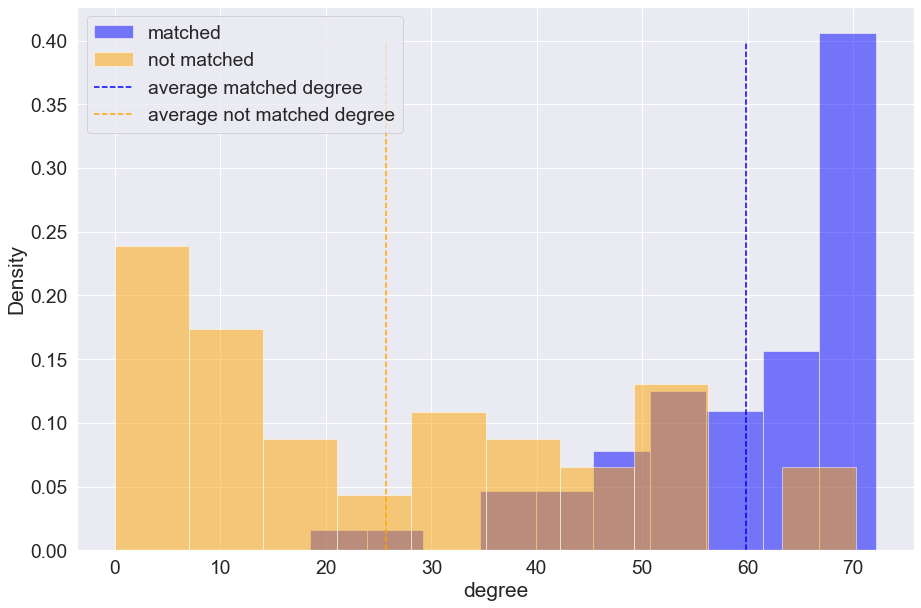

In [260]:
# plt.hist(in_matched, bins = 10, label = 'matched', alpha = 0.75)
# plt.hist(in_unmatched, bins = 10, label = 'not matached', alpha = 0.75)
# plt.legend()
# plt.xlabel('degree')

counts, bins = np.histogram(in_matched, bins = 10)
plt.hist(bins[:-1], bins, weights = counts/(sum(counts)), label = 'matched', alpha = .5, color = 'blue')
counts, bins = np.histogram(in_unmatched, bins=10)
plt.hist(bins[:-1], bins, weights = counts/(sum(counts)), label = 'not matched', alpha = .5, color = 'orange')
plt.vlines(np.mean(in_matched),0,0.4,linestyles='dashed', color = 'blue', label='average matched degree')
plt.vlines(np.mean(in_unmatched),0,0.4,linestyles='dashed', color = 'orange', label='average not matched degree')

plt.legend()
plt.xlabel('degree')
plt.ylabel('Density')
plt.savefig('Figure5.png')

In [278]:
Ael = load_adj(times[stamp])
Bel = load_adj(times[stamp+1])
nodesA = list(set(np.concatenate((Ael['from'],Ael['to']), axis=0)))
nodesB = list(set(np.concatenate((Bel['from'],Bel['to']), axis=0)))
nodesAB = list(np.setdiff1d(nodesB, nodesA))
abloc = nodesB.index(nodesAB[0])
na = len(nodesA)
n = len(nodesB)
perm =  np.append(np.setdiff1d(np.arange(n),abloc), abloc)

A = np.zeros((n,n))
B = np.zeros((n,n))
row_list_A = [nodesB.index(x) for x in Ael['from']]
col_list_A = [nodesB.index(x) for x in Ael['to']]
A[row_list_A, col_list_A] = Ael['weight']
row_list_B = [nodesB.index(x) for x in Bel['from']]
col_list_B = [nodesB.index(x) for x in Bel['to']]
B[row_list_B, col_list_B] = Bel['weight']
A = A[perm][:,perm]
B = B[perm][:,perm]
A = pass_to_ranks(A)
B = pass_to_ranks(B)
Atil = 2*A[:na,:na] - np.ones((na,na))
A = np.zeros((n,n))
A[:na,:na] = Atil
B = 2*B - np.ones((n,n))
#perm
gmp = {'maximize':True, 'shuffle_input': False, 'init_J': np.identity(n)}
res = quadratic_assignment(A,B, options=gmp)
# match_ratio(res.col_ind, n)


In [63]:
rng = np.random.RandomState(0)
perm = rng.permutation(10)
p = np.eye(10)
p = p[perm,:]
print(perm)
print(p)

[2 8 4 9 1 6 7 3 0 5]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [91]:
fgmi = np.zeros(50)
for i in range(len(fgmi)):
    rng = np.random.RandomState(i)
    perm = rng.permutation(n)
#     rands[i] = _calc_score(A,B,perm)
    Bi = B[perm][:, perm]
    gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)[np.argsort(perm)][:, np.arange(n)]}
    fgmi[i] = quadratic_assignment(A,B, options=gmp).fun 
    
# gmp = {'maximize':True, 'shuffle_input': True, 'P0': np.identity(n), 'rng': i}
# fgmi = [quadratic_assignment(A,B, options=gmp).fun for i in range(50)]
gmp = {'maximize':True, 'shuffle_input': True}
fgmb = [quadratic_assignment(A,B, options=gmp).fun for i in range(50)]
print("50 initializations each")
print("f(GM_I) +/ 2 s.e.:  " , np.mean(fgmi), "+/-", 2*sem(fgmi))
print("f(GM_P_26) +/ 2 s.e.:  ", np.mean(fgmb), "+/-", sem(fgmb))

50 initializations each
f(GM_I) +/ 2 s.e.:   4623.850160202627 +/- 0.6210245235583715
f(GM_P_26) +/ 2 s.e.:   4634.82228421073 +/- 0.0


In [93]:
fgmb

[4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073,
 4634.82228421073]

In [89]:
bary = np.ones((n,n)) / n
print(np.trace(A@bary@B.T@bary.T))

3280.8199240795484


In [101]:
for i in range(len(times)-1):
    # constructing the adjacency matrices
    Ael = load_adj(times[i])
    Bel = load_adj(times[i+1])
    nodes_A = np.concatenate((Ael['from'],Ael['to']), axis=0)
    nodes_A = list(set(nodes_A))
    nodes_B = np.concatenate((Bel['from'],Bel['to']), axis=0)
    nodes_B = list(set(nodes_B))
    print(i, len(nodes_A), len(nodes_B))
    

0 27 25
1 25 59
2 59 74
3 74 44
4 44 96
5 96 87
6 87 85
7 85 96
8 96 104
9 104 108
10 108 107
11 107 101
12 101 104
13 104 108
14 108 107
15 107 105
16 105 108
17 108 108
18 108 106
19 106 112
20 112 113
21 113 113
22 113 114
23 114 111
24 111 109
25 109 123
26 123 121
27 121 122
28 122 124
29 124 115
30 115 118
31 118 112
32 112 102
33 102 108
34 108 106
35 106 108
36 108 113
37 113 110
38 110 106


In [449]:
n_edges = np.zeros(len(times))
n_vert = np.zeros(len(times))
for i in range(len(times)):
    # constructing the adjacency matrices
    Ael = load_adj(times[i])
    nodes = np.concatenate((Ael['from'],Ael['to']), axis=0)
    n_edges[i] = len(nodes)
    nodes = list(set(nodes))
    n_vert[i] = len(nodes)


In [264]:
n_edges/2

array([  372.,   227.,  1513.,  2467.,   435.,  3756.,  3427.,  3550.,
        4722.,  6292.,  6670.,  7637.,  5646.,  7852.,  7905.,  7613.,
        8639.,  9065.,  9686.,  8880., 10730., 11414., 11784., 12256.,
       10869.,  9401., 14238., 13935., 14017., 13648., 12293., 12410.,
       11066.,  9597., 10779.,  9777., 10576., 10598., 10542., 10022.])

In [241]:
n_vert

array([ 27.,  25.,  59.,  74.,  44.,  96.,  87.,  85.,  96., 104., 108.,
       107., 101., 104., 108., 107., 105., 108., 108., 106., 112., 113.,
       113., 114., 111., 109., 123., 121., 122., 124., 115., 118., 112.,
       102., 108., 106., 108., 113., 110., 106.])

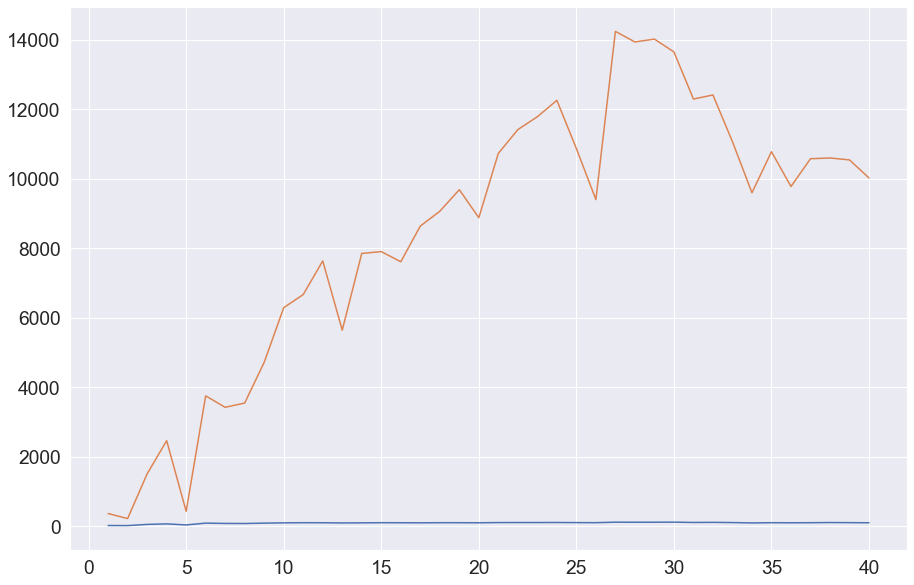

In [243]:
plt.plot(np.arange(1, len(times)+1), n_vert)
plt.plot(np.arange(1, len(times)+1), n_edges/2)


<ipython-input-450-e2e7c2c01af5>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


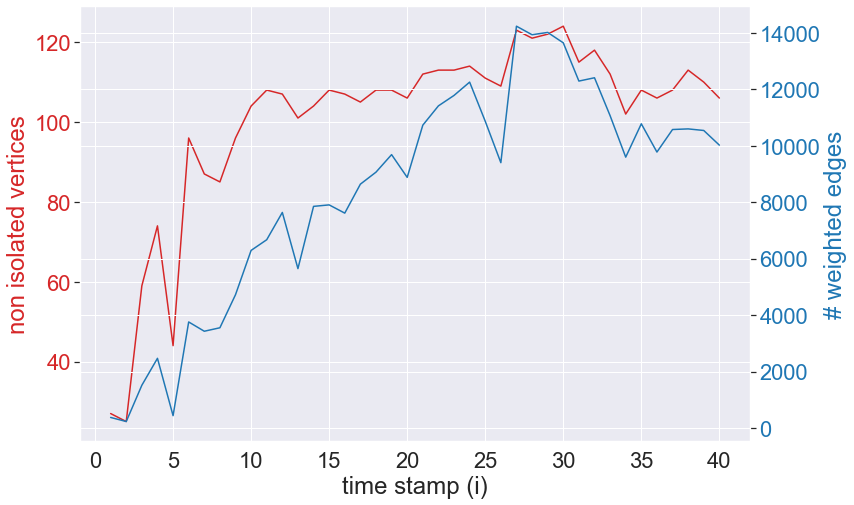

In [450]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time stamp (i)')
ax1.set_ylabel('non isolated vertices', color=color)
ax1.plot(np.arange(1, len(times)+1), n_vert, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('# weighted edges', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(1, len(times)+1), n_edges/2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.show()
fig.savefig('Figure1.png')

In [71]:
def load_adj(file):
    df = pd.read_csv(f'org_sig1_max/{file}.csv', names = ['from', 'to', 'weight'])
    return df
def pnsplit(f, t):
    f = [x.split('_') for x in f]
    t = [x.split('_') for x in t]
    fn = []
    fp = []
    tn = []
    tp = []
    for i in range(len(f)):
        if f[i][2] == t[i][2]:
            if f[i][2] == 'nega':
                fn.append(f[i][:-1])
                tn.append(t[i][:-1])
            else:
                fp.append(f[i][:-1])
                tp.append(t[i][:-1])
                
    fn = np.asarray(fn).astype(int)
    fp = np.asarray(fp).astype(int)
    tn = np.asarray(tn).astype(int)
    tp = np.asarray(tp).astype(int)
    return fn, fp, tn, tp

edge_list1 = load_adj(times[0])
f = np.asarray(edge_list1['from'])
t = np.asarray(edge_list1['to'])
fn, fp, tn, tp = pnsplit(f, t)


Text(0.5, 1.0, 'posi')

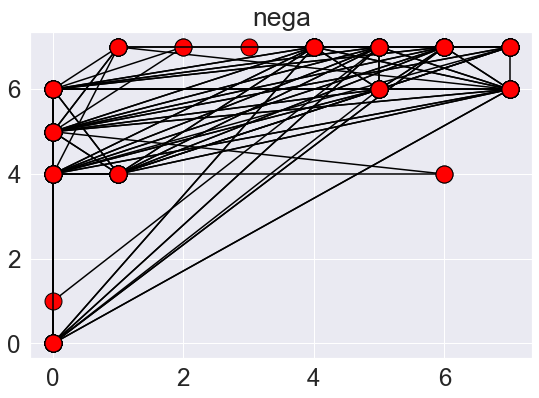

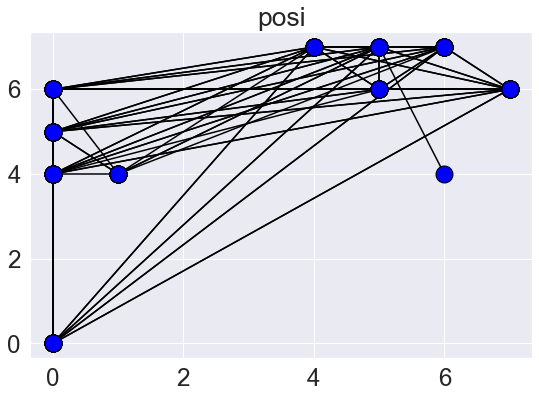

In [70]:
sns.set_context('talk')

sns.set(rc={'figure.figsize':(9,6)})
sns.set(font_scale = 2.2)
for i in range(len(fn)):
    x = [fn[i,1], tn[i,1]]
    y = [fn[i,0], tn[i,0]]
    plt.plot(x,y, marker='o', color='black', markersize=17, markerfacecolor='red')
plt.title('nega')

plt.figure()
for i in range(len(fp)):
    x = [fp[i,1], tp[i,1]]
    y = [fp[i,0], tp[i,0]]
    plt.plot(x,y, marker='o', color='black', markersize=17, markerfacecolor='blue')
plt.title('posi')


In [426]:
stamp =27
Ael = load_adj(times[stamp])
Bel = load_adj(times[stamp+1])
nodesA = set(Ael['from'])
nodesB = set(Bel['from'])
nodes = list(nodesA) + list(nodesB-nodesA)

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 2)
n = len(nodes)
A = np.zeros((n,n))
B = np.zeros((n,n))
row_list_A = [nodes.index(x) for x in Ael['from']]
col_list_A = [nodes.index(x) for x in Ael['to']]
A[row_list_A, col_list_A] = Ael['weight']
row_list_B = [nodes.index(x) for x in Bel['from']]
col_list_B = [nodes.index(x) for x in Bel['to']]
B[row_list_B, col_list_B] = Bel['weight']
A = pass_to_ranks(A)
B = pass_to_ranks(B)
opt_ofv = (A*B).sum()
print(opt_ofv)
gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)}
res = quadratic_assignment(Atil,Btil, options=gmp)
nodes = np.asarray(nodes)
known = nodes[res.col_ind != np.arange(n)]
thought = nodes[res.col_ind][res.col_ind != np.arange(n)]
dists = np.zeros(len(known))
# incind = np.arange(n)[res.col_ind != np.arange(n)]

for i in range(len(known)):

    k = known[i]
    ks = np.asarray(k.split('_'))
    ktype = ks[-1]
    ks = ks[:-1].astype(int)
    t = thought[i]
    ts = np.asarray(t.split('_'))
    ttype = ts[-1]
    ts = ts[:-1].astype(int)
    plt.arrow(ks[1],ks[0],ts[1]-ks[1], ts[0]-ks[0],color='black', linewidth = 0.1,length_includes_head = True,head_width=0.1, head_length=0.15)
    if ktype == 'nega':
        plt.scatter(ks[1], ks[0], marker='o', color='red', s=130)
    else:
        plt.scatter(ks[1], ks[0], marker='o', color='blue', s=130)
    if ttype == 'nega':
        plt.scatter(ts[1], ts[0], marker='o', color='red', s=130)
    else:
        plt.scatter(ts[1], ts[0], marker='o', color='blue', s=130)
        
#     plt.arrow(ks[1],ks[0],ts[1]-ks[1], ts[0]-ks[0],color='black', linewidth = 0.1,length_includes_head = True,head_width=0.1, head_length=0.15)
#     plt.legend()
#     print(ktype,ttype)
    dists[i] = np.linalg.norm(ks-ts)

txt = 'posi'
plt.figtext(0.2, 0.83, txt, wrap=True, horizontalalignment='center', fontsize=15, color='blue')
txt = 'nega'
plt.figtext(0.2, 0.8, txt, wrap=True, horizontalalignment='center', fontsize=15, color='red')
plt.title('Purported Location -> Matched Location')



4541.053424074738


ValueError: `P0` matrix must have shape m' x m', where m'=n-m

[7.28010989 1.         3.60555128 1.         5.         7.61577311
 3.16227766 6.32455532 5.09901951 1.         8.06225775 1.
 3.60555128 5.38516481 1.         2.23606798 5.83095189 7.07106781
 5.38516481 2.         6.         7.61577311 1.         1.
 1.         5.         7.61577311 1.         2.         6.40312424
 4.47213595 1.         1.41421356 4.12310563 1.         3.60555128
 6.70820393 2.23606798 5.09901951 1.         1.41421356 7.61577311
 4.12310563 5.        ]


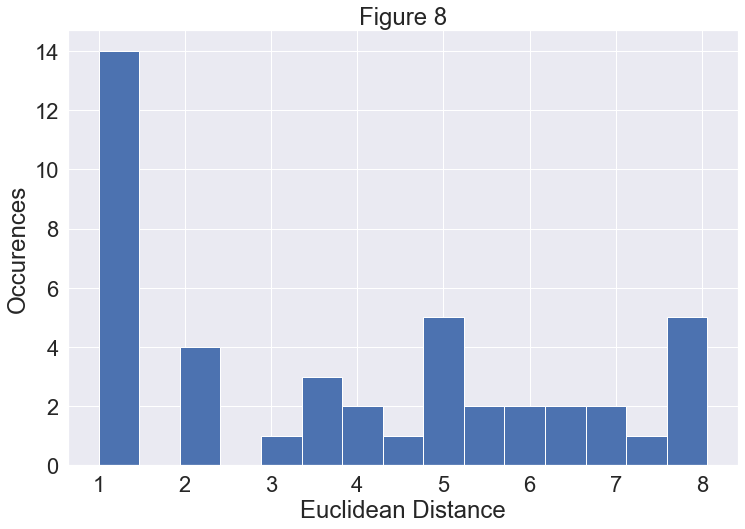

In [508]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 2)
plt.hist(dists, bins = 15)
plt.ylabel('Occurences')
plt.xlabel('Euclidean Distance')
plt.title('Figure 8')
# plt.savefig('figure8.png')
print(dists)

In [229]:
nega = 0
posi = 0
for i in known:
    split = np.asarray(i.split('_'))
#     print(split)
    typ = split[-1]
    if typ == 'nega':
        nega += 1
    else:
        posi+=1

In [230]:
print(nega, posi)

14 25


In [397]:
# stamp =27
# Ael = load_adj(times[23])
# Bel = load_adj(times[33])
# nodesA = set(Ael['from'])
# nodesB = set(Bel['from'])
# nodesB = list(nodesA) + list(nodesB-nodesA)
# nodesA = list(nodesA)

# na = len(nodesA)
# nb = len(nodesB)
# n = max(na,nb)
# print(nb)
# A = np.zeros((na,na))
# B = np.zeros((nb,nb))
# row_list_A = [nodesA.index(x) for x in Ael['from']]
# col_list_A = [nodesA.index(x) for x in Ael['to']]
# A[row_list_A, col_list_A] = Ael['weight']
# row_list_B = [nodesB.index(x) for x in Bel['from']]
# col_list_B = [nodesB.index(x) for x in Bel['to']]
# B[row_list_B, col_list_B] = Bel['weight']
# A = pass_to_ranks(A)
# B = pass_to_ranks(B)
# Atil, Btil = adopted_pad(A,B)
gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)}
res = quadratic_assignment(Atil,Btil, options=gmp)
match_ratio(res.col_ind,n)
nodes = np.asarray(nodesB)
known = nodes[res.col_ind != np.arange(nb)]
thought = nodes[res.col_ind][res.col_ind != np.arange(n)]
A, B = naive_pad(A,B)
dists = np.zeros(len(known))
# incind = np.arange(n)[res.col_ind != np.arange(n)]

for i in range(len(known)):

    k = known[i]
    ks = np.asarray(k.split('_'))
    ktype = ks[-1]
    ks = ks[:-1].astype(int)
    t = thought[i]
    ts = np.asarray(t.split('_'))
    ttype = ts[-1]
    ts = ts[:-1].astype(int)
    plt.arrow(ks[1],ks[0],ts[1]-ks[1], ts[0]-ks[0],color='black', linewidth = 0.1,length_includes_head = True,head_width=0.1, head_length=0.15)
    if ktype == 'nega':
        plt.scatter(ks[1], ks[0], marker='o', color='red', s=130)
    else:
        plt.scatter(ks[1], ks[0], marker='o', color='blue', s=130)
    if ttype == 'nega':
        plt.scatter(ts[1], ts[0], marker='o', color='red', s=130)
    else:
        plt.scatter(ts[1], ts[0], marker='o', color='blue', s=130)
        
#     plt.arrow(ks[1],ks[0],ts[1]-ks[1], ts[0]-ks[0],color='black', linewidth = 0.1,length_includes_head = True,head_width=0.1, head_length=0.15)
#     plt.legend()
#     print(ktype,ttype)
    dists[i] = np.linalg.norm(ks-ts)

txt = 'posi'
plt.figtext(0.2, 0.83, txt, wrap=True, horizontalalignment='center', fontsize=15, color='blue')
txt = 'nega'
plt.figtext(0.2, 0.8, txt, wrap=True, horizontalalignment='center', fontsize=15, color='red')
plt.title('Purported Location -> Matched Location')

<ipython-input-397-a53aa964ad23>:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  known = nodes[res.col_ind != np.arange(nb)]


IndexError: index 102 is out of bounds for axis 0 with size 102

In [252]:
def calc_score(A, B, perm):
    # equivalent to objective function but avoids matmul
    return np.sum(A * B[perm][:, perm])
def adopted_pad(A,B):
    def pad(X, n):
        X_pad = np.zeros((n[1],n[1]))
        X_pad[:n[0],:n[0]] = X
        return X_pad
    A_n = A.shape[0]
    B_n = B.shape[0]
    n = np.sort([A_n, B_n])
    A_til = 2*A - np.ones((A_n, A_n))
    B_til = 2*B - np.ones((B_n, B_n))
    if A_n == n[0]:
        A_til = pad(A_til, n)
    else:
        B_til = pad(B_til, n)
    return A_til, B_til
def naive_pad(A,B):
    def pad(X, n):
        A_pad = np.zeros((n[1],n[1]))
        A_pad[:n[0],:n[0]] = X
        return A_pad
    n = np.sort([A.shape[0], B.shape[0]])
    if A.shape[0] == n[0]:
        A = pad(A, n)
    else:
        B = pad(B, n)
        
    return A, B

0.639344262295082
44


Text(0.5, 1.0, 'Purported Location -> Matched Location')

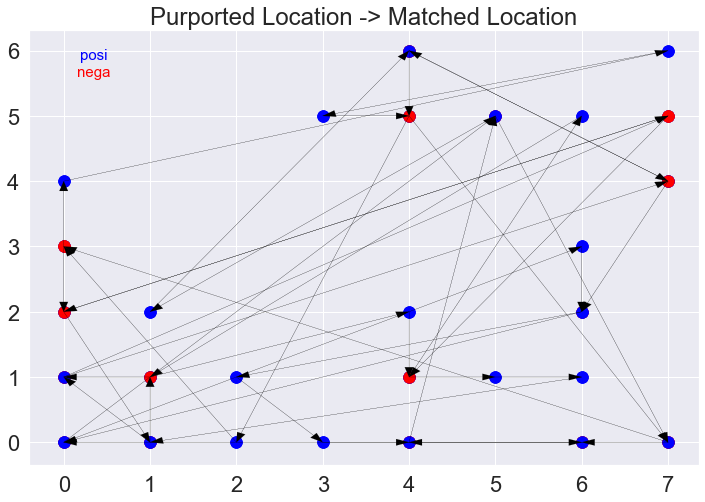

In [507]:
stamp =0
Ael = load_adj(times[27])
Bel = load_adj(times[28])
nodeA = set(np.concatenate((Ael['from'], Ael['to'])))
nodeB = set(np.concatenate((Bel['from'], Bel['to'])))
intersect = list(nodeB & nodeA)
nodesA = intersect + list(nodeA-nodeB)
nodesB = intersect + list(nodeB-nodeA)

# print(len(nodeB))
# print(len(nodesB))
# print(len(nodeA))
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 2)
na = len(nodesA)
nb = len(nodesB)
n = max(na, nb)
A = np.zeros((na,na))
B = np.zeros((nb,nb))
row_list_A = [nodesA.index(x) for x in Ael['from']]
col_list_A = [nodesA.index(x) for x in Ael['to']]
A[row_list_A, col_list_A] = Ael['weight']
row_list_B = [nodesB.index(x) for x in Bel['from']]
col_list_B = [nodesB.index(x) for x in Bel['to']]
B[row_list_B, col_list_B] = Bel['weight']
A = pass_to_ranks(A)
B = pass_to_ranks(B)
Atil, Btil = adopted_pad(A,B)
A, B = naive_pad(A,B)
opt_ofv = (Atil*Btil).sum()
gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)}
res = quadratic_assignment(Atil,Btil, options=gmp)
print(match_ratio(res.col_ind,n))
nodes = np.asarray(nodesB)
known = nodes[res.col_ind != np.arange(n)]
thought = nodes[res.col_ind][res.col_ind != np.arange(n)]
#thought = np.random.permutation(known)
print(len(known))
A, B = naive_pad(A,B)
dists = np.zeros(len(known))

for i in range(len(known)):

    k = known[i]
    ks = np.asarray(k.split('_'))
    ktype = ks[-1]
    ks = ks[:-1].astype(int)
    t = thought[i]
    ts = np.asarray(t.split('_'))
    ttype = ts[-1]
    ts = ts[:-1].astype(int)
    plt.arrow(ks[1],ks[0],ts[1]-ks[1], ts[0]-ks[0],color='black', linewidth = 0.1,length_includes_head = True,head_width=0.1, head_length=0.15)
    if ktype == 'nega':
        plt.scatter(ks[1], ks[0], marker='o', color='red', s=130)
    else:
        plt.scatter(ks[1], ks[0], marker='o', color='blue', s=130)
    if ttype == 'nega':
        plt.scatter(ts[1], ts[0], marker='o', color='red', s=130)
    else:
        plt.scatter(ts[1], ts[0], marker='o', color='blue', s=130)
        
#     plt.arrow(ks[1],ks[0],ts[1]-ks[1], ts[0]-ks[0],color='black', linewidth = 0.1,length_includes_head = True,head_width=0.1, head_length=0.15)
#     plt.legend()
#     print(ktype,ttype)
    dists[i] = np.linalg.norm(ks-ts)

txt = 'posi'
plt.figtext(0.2, 0.83, txt, wrap=True, horizontalalignment='center', fontsize=15, color='blue')
txt = 'nega'
plt.figtext(0.2, 0.8, txt, wrap=True, horizontalalignment='center', fontsize=15, color='red')
plt.title('Purported Location -> Matched Location')

In [375]:
from scipy.stats import sem
t = 1
ofvs = np.zeros((len(times)-1,2)) # [opt_ofv, gm_ofv]
for i in range(len(times)-1):
    # constructing the adjacency matrices
    Ael = load_adj(times[i])
    Bel = load_adj(times[i+1])
    nodeA = set(np.concatenate((Ael['from'], Ael['to'])))
    nodeB = set(np.concatenate((Bel['from'], Bel['to'])))
    intersect = list(nodeB & nodeA)
    nodesA = intersect + list(nodeA-nodeB)
    nodesB = intersect + list(nodeB-nodeA)
    na = len(nodesA)
    nb = len(nodesB)

    A = np.zeros((na,na))
    B = np.zeros((nb,nb))
    row_list_A = [nodesA.index(x) for x in Ael['from']]
    col_list_A = [nodesA.index(x) for x in Ael['to']]
    A[row_list_A, col_list_A] = Ael['weight']
    row_list_B = [nodesB.index(x) for x in Bel['from']]
    col_list_B = [nodesB.index(x) for x in Bel['to']]
    B[row_list_B, col_list_B] = Bel['weight']
    A = pass_to_ranks(A)
    B = pass_to_ranks(B)
    Atil, Btil = adopted_pad(A,B)
    A, B = naive_pad(A,B)
    gmp = {'maximize':True, 'shuffle_input': True}
    res = quadratic_assignment(Atil,Btil, options=gmp)
    gm_ofv_ns = calc_score(A, B, res.col_ind)
    opt_ofv = (A*B).sum()
    ofvs[i,:] = [opt_ofv, gm_ofv_ns]

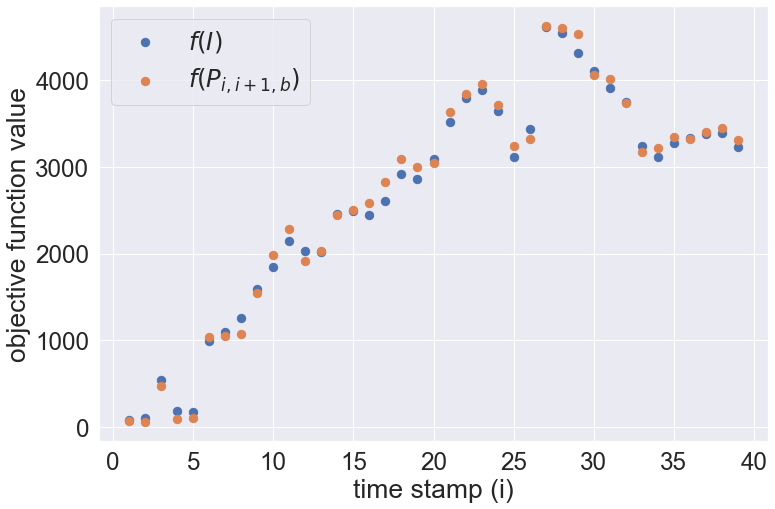

In [376]:
# collapse
#sns.set_context('talk')
sns.set(font_scale = 2.2)
#sns.set(rc={'figure.figsize':(12,8)})
plt.scatter(np.arange(1, len(times)), ofvs[:,0], label = r'$f (I)$', s=70)
plt.scatter(np.arange(1, len(times)), ofvs[:,1], label = r'$f (P_{i, i+1, b})$', s=70)
#plt.errorbar(np.arange(len(times)-1),ofvs[:,1], ofvs[:,2],label = 'average gm ofv +/- 2 s.e.',marker='o', fmt = ' ' ,capsize=3, elinewidth=1, markeredgewidth=1,color='orange')
plt.legend()
#plt.title('Figure 1')
plt.ylabel('objective function value')
plt.xlabel('time stamp (i)')
plt.savefig('Figure2.png')

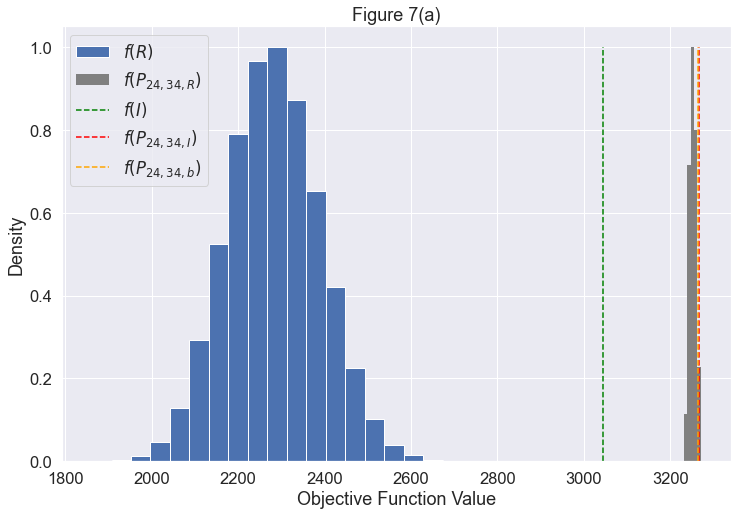

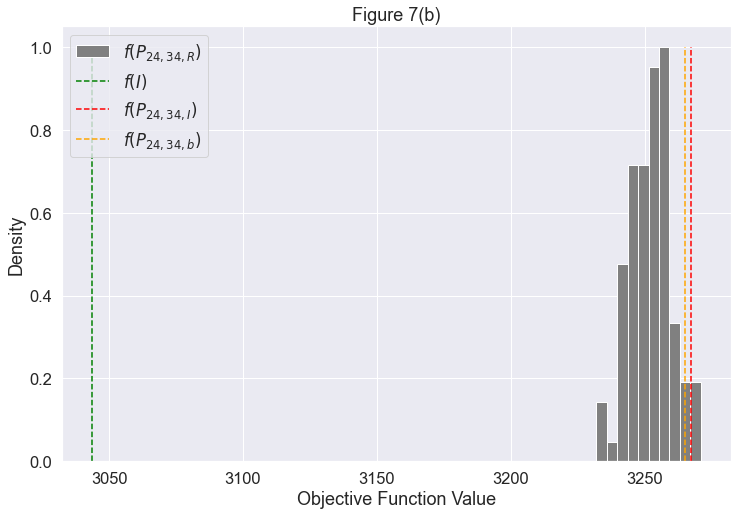

In [437]:
import seaborn as sns

# sns.set(rc={'figure.figsize':(9,6)})
sns.set(font_scale = 1.5)
counts, bins = np.histogram(rands, bins = 20)
plt.hist(bins[:-1], bins, weights = counts/(max(counts)), label = r'$f(R)$')
counts, bins = np.histogram(fgmrp, bins=5)
plt.hist(bins[:-1], bins, weights = counts/(max(counts)), label = r'$f(P_{24,34, R})$', color = 'grey', lw=0)
#plt.hist(rands, bins=20, density=True, label = 'f(randomP)')
# plt.hist(fgmrp, bins = 10, label = 'f(GM(P_r))')
plt.vlines(fp,0,1,linestyles='dashed', color = 'green', label=r'$f(I)$')
plt.vlines(fgmp,0,1,linestyles='dashed', color = 'red', label=r'$f(P_{24,34, I})$')
plt.vlines(fgmb,0,1,linestyles='dashed', color = 'orange', label=r'$f(P_{24,34, b})$')
#plt.vlines(fgmrp,0,15000,linestyles='dashed', color = 'blue', label='f(GM(P_r))')

plt.legend()
plt.title('Figure 7(a)')
plt.xlabel('Objective Function Value')
plt.ylabel('Density')
plt.savefig('Figure7a.png')
#plt.title('Figure 3')
plt.figure()

sns.set(font_scale = 1.5)
#sns.set(rc={'figure.figsize':(15,10)})
counts, bins = np.histogram(fgmrp, bins=10)
plt.hist(bins[:-1], bins, weights = counts/(max(counts)), label = r'$f(P_{24,34, R})$', color = 'grey')
#plt.hist(rands, bins=20, density=True, label = 'f(randomP)')
# plt.hist(fgmrp, bins = 10, label = 'f(GM(P_r))')
plt.vlines(fp,0,1,linestyles='dashed', color = 'green', label=r'$f(I)$')
plt.vlines(fgmp,0,1,linestyles='dashed', color = 'red', label=r'$f(P_{24,34, I})$')
plt.vlines(fgmb,0,1,linestyles='dashed', color = 'orange', label=r'$f(P_{24,34, b})$')
#plt.vlines(fgmrp,0,15000,linestyles='dashed', color = 'blue', label='f(GM(P_r))')

plt.legend()
plt.title('Figure 7(b)')
plt.xlabel('Objective Function Value')
plt.ylabel('Density')
#plt.title('Figure 3')
plt.savefig('Figure7b.png')
# plt.savefig('Figure4a.png')

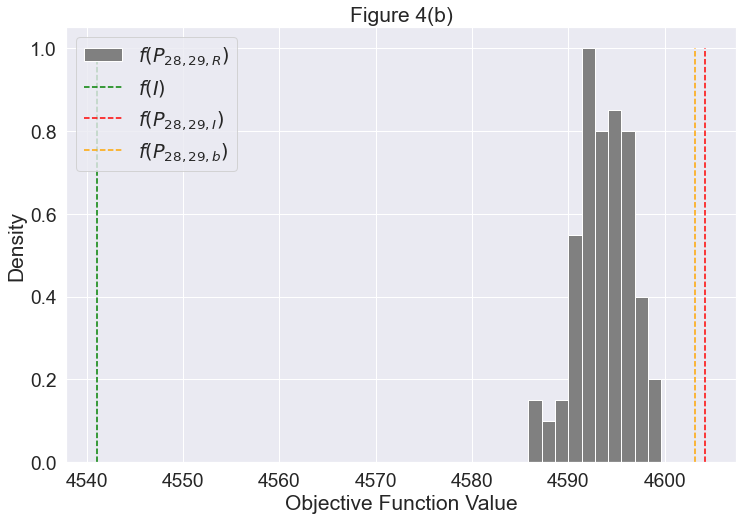

In [383]:
import seaborn as sns
sns.set(font_scale = 1.75)
#sns.set(rc={'figure.figsize':(15,10)})
counts, bins = np.histogram(fgmrp, bins=10)
plt.hist(bins[:-1], bins, weights = counts/(max(counts)), label = r'$f(P_{28,29, R})$', color = 'grey')
#plt.hist(rands, bins=20, density=True, label = 'f(randomP)')
# plt.hist(fgmrp, bins = 10, label = 'f(GM(P_r))')
plt.vlines(fp,0,1,linestyles='dashed', color = 'green', label=r'$f(I)$')
plt.vlines(fgmp,0,1,linestyles='dashed', color = 'red', label=r'$f(P_{28,29, I})$')
plt.vlines(fgmb,0,1,linestyles='dashed', color = 'orange', label=r'$f(P_{28,29, b})$')
#plt.vlines(fgmrp,0,15000,linestyles='dashed', color = 'blue', label='f(GM(P_r))')

plt.legend()
plt.title('Figure 4(b)')
plt.xlabel('Objective Function Value')
plt.ylabel('Density')
#plt.title('Figure 3')
plt.savefig('Figure4b.png')

In [416]:
fp = (A*B).sum()
gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)}
res = quadratic_assignment(Atil,Btil, options=gmp)
fgmp = calc_score(A,B,res.col_ind)
mrgmp = match_ratio(res.col_ind, n)
gmp = {'maximize':True, 'shuffle_input': True}
res = quadratic_assignment(Atil,Btil, options=gmp)
fgmb = calc_score(A,B,res.col_ind)
mrgmb = match_ratio(res.col_ind,n)
fgmrp = np.zeros(100)
mrgmrp = 0
for i in range(100):
    rng = np.random.RandomState(i)
    perm = rng.permutation(n)
    p = np.eye(n)
    p = p[perm,:]
    gmp = {'maximize':True, 'shuffle_input': False, 'P0': p}
    # fgmrp = min([quadratic_assignment(A,B, options=gmp).fun for i in range(100)])
    res = quadratic_assignment(Atil,Btil, options=gmp)
    fgmrp[i] = calc_score(A,B,res.col_ind)
    mrgmrp += match_ratio(res.col_ind,n)

mrgmrp = mrgmrp/100
rands = np.zeros(100000)
for i in range(len(rands)):
    rng = np.random.RandomState(i)
    perm = rng.permutation(n)
    rands[i] = _calc_score(A,B,perm)

In [551]:
from sklearn.metrics.pairwise import euclidean_distances
from qap_sim2 import quadratic_assignment_sim

Ael = load_adj(times[27])
Bel = load_adj(times[28])
nodeA = set(np.concatenate((Ael['from'], Ael['to'])))
nodeB = set(np.concatenate((Bel['from'], Bel['to'])))
intersect = list(nodeB & nodeA)
nodesA = intersect + list(nodeA-nodeB)
nodesB = intersect + list(nodeB-nodeA)

na = len(nodesA)
nb = len(nodesB)
n = max(na, nb)
A = np.zeros((na,na))
B = np.zeros((nb,nb))
row_list_A = [nodesA.index(x) for x in Ael['from']]
col_list_A = [nodesA.index(x) for x in Ael['to']]
A[row_list_A, col_list_A] = Ael['weight']
row_list_B = [nodesB.index(x) for x in Bel['from']]
col_list_B = [nodesB.index(x) for x in Bel['to']]
B[row_list_B, col_list_B] = Bel['weight']
A = pass_to_ranks(A)
B = pass_to_ranks(B)
Atil, Btil = adopted_pad(A,B)
A, B = naive_pad(A,B)
nodes = np.asarray(nodesB)
dist = [x.split('_')[:-1] for x in nodes]
dist = np.asarray(dist).astype(int)
D = euclidean_distances(dist,dist)
S = exp(-D)

opt_ofv = (Atil*Btil).sum()
gmp = {'maximize':True, 'shuffle_input': False, 'P0': np.identity(n)}
simo = {'shuffle_input': False, 'init_J': np.identity(n)}
res = quadratic_assignment_sim(A,B, True, S)
print(match_ratio(res.col_ind,n))

known = nodes[res.col_ind != np.arange(n)]
thought = nodes[res.col_ind][res.col_ind != np.arange(n)]
# thought = np.random.permutation(known)
print(len(known))
A, B = naive_pad(A,B)
dists = np.zeros(len(known))
for i in range(len(known)):

    k = known[i]
    ks = np.asarray(k.split('_'))
    ks = ks[:-1].astype(int)
    t = thought[i]
    ts = np.asarray(t.split('_'))
    ts = ts[:-1].astype(int)
    dists[i] = np.linalg.norm(ks-ts)


0.7377049180327869
32


Text(5.5, 4.5, 'match ratio: 0.738')

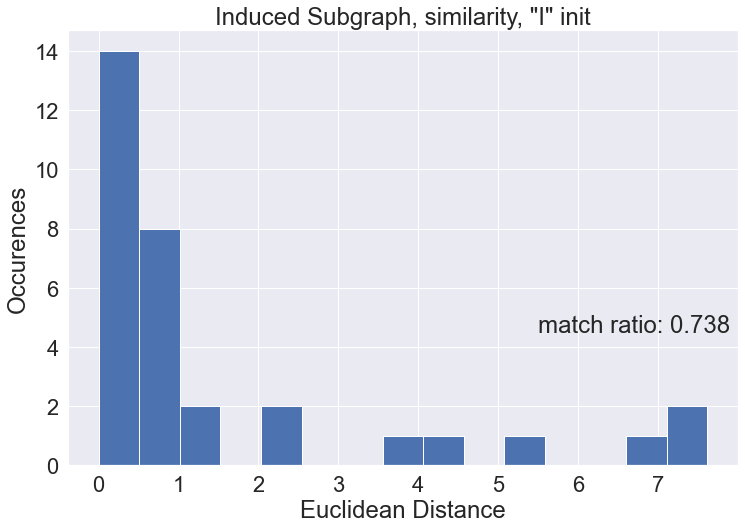

In [552]:
plt.hist(dists, bins=15)
plt.title('Induced Subgraph, similarity, "I" init')
plt.xlabel('Euclidean Distance')
plt.ylabel('Occurences')
plt.text(5.5,4.5, f'match ratio: {np.round(match_ratio(res.col_ind,n),3)}')

In [553]:
print(dists)

[0.         0.         1.41421356 0.         5.09901951 0.
 1.         4.         2.23606798 1.         0.         1.
 0.         0.         1.         0.         2.23606798 0.
 1.         1.         0.         7.21110255 4.12310563 0.
 6.70820393 1.41421356 1.         0.         0.         7.61577311
 0.         1.        ]
